
# **Assignment 4: Next Character Prediction in a Text - December 2024**


- **Author:** Elio Gargiulo
- **ID:** 869184
- **Course:** Advanced Machine Learning
- **A.Y:** 2024/25
- **University:** Milano Bicocca - Master Degree in Computer Science




Starting from the provided skeleton of the code:

- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance



# **Initialization**


## **Initialization: Importing the Libraries**
Importing the necessary libraries.

In [ ]:
# System
import sys
import io
import numpy as np
import pandas as pd
import random

# For models and training
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# File importing from Google Drive
from google.colab import drive

## **Initialization: Importing the Data**
The data that will be imported is from an external text file "divina_commedia.txt" from Google Drive.

In [ ]:
# Mouting the drive
drive.mount('/content/drive', force_remount=True)

# Saving the main path to the data
main_path = '/content/drive/MyDrive/Colab Notebooks/Assignment 4/'

# File name to open
file_name = 'divina_commedia.txt'

# Full Path
path = main_path + file_name

# Opening the file
print('OPENING THE FILE: ' + file_name)
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()

Mounted at /content/drive
OPENING THE FILE: divina_commedia.txt


Let's analyze the text file to see if the importing has been correctly done.

In [ ]:
# Printing useful information about the file
print('FILE OPENED: ', file_name)
print('Text File Length:', len(text))
print()

# Showing the first 1000 characters
print('\n\n\n\n\n', '****** First 1000 Characters *******', '\n\n\n\n')
print(text[0:1000])

FILE OPENED:  divina_commedia.txt
Text File Length: 558240






 ****** First 1000 Characters ******* 




inferno



inferno: canto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

e come quei che con lena affannata
  uscito fuor del pelago a l

# **Preparing the Data**

This section prepares the data that will be used by the LSTM models. First we need an encoding (and decoding) of our characters through dictionaries, since we are going to use the indices in the following steps for the actual one-hot encoding. Finally there will be implemented a function to split the set into train, test and validation sets while also building the sequences using the chunk length and step.

## **Preparing the Data: Dictionaries for Encoding and Decoding**

Now that the file has been opened, the characters of the txt file are going to be analyzed.

In [ ]:
# Total Character in the txt file
chars = sorted(list(set(text)))
print('Total Characters (Length): ', len(chars))

# Building a dict with the characters/indexes
char_indices = dict((c, i) for i, c in enumerate(chars)) # Encode to input
indices_char = dict((i, c) for i, c in enumerate(chars)) # Decode to output

# Using a Dataframe to display the information about each character and its corresponding index in the dictionary
df_char_indices = pd.DataFrame(list(char_indices.items()), columns=["Character", "Index"])
df_indices_char = pd.DataFrame(list(indices_char.items()), columns=["Index", "Character"])

Total Characters (Length):  40


In [ ]:
# Printing Char Indices
print("Char Indices:")
df_char_indices

Char Indices:


,Character,Index
0,\n,0
1,,1
2,!,2
3,"""",3
4,',4
5,(,5
6,),6
7,",",7
8,-,8
9,.,9


In [ ]:
# Printing Indices Char
print("Indices Char:")
df_indices_char

Indices Char:


,Index,Character
0,0,\n
1,1,
2,2,!
3,3,""""
4,4,'
5,5,(
6,6,)
7,7,","
8,8,-
9,9,.


## **Preparing the Data: One-Hot Encoding**

We will use one-hot encoding to encode our characters using the following function.

In [ ]:
# Function for one-hot encoding
def one_hot_encode(sequences, next_chars, num_chars, maxlen):
    X_one_hot = np.zeros((len(sequences), maxlen, num_chars), dtype=bool)
    y_one_hot = np.zeros((len(sequences), num_chars), dtype=bool)

    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            X_one_hot[i, t, char_indices[char]] = 1  # One-hot encode X
        y_one_hot[i, char_indices[next_chars[i]]] = 1  # One-hot encode y
    return X_one_hot, y_one_hot


## **Preparing the Data: Encoding and Set division into Train, Test and Validation Sets**

The following function is called before the implementation of each model that will be tested out. It builds the sequences for the LSTM model using the chunk length and step size, applies the one-hot encoding and finally splits the dataset using "train_test_split" into train, validation and test sets, following these percentages:

- 80% for Training
- 10% for Validation
- 10% for Test

In [ ]:
# Function for preparing the data for the models. This function helps with tuning
# the parameters without repeating too much code
def prepare_text_data(text, chars, maxlen=30, step=3, val_split=0.1, test_split=0.1):

    # Saving the length of chars
    num_chars = len(chars)

    # Building sequences
    sequences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sequences.append(text[i: i + maxlen])  # Input Sequence
        next_chars.append(text[i + maxlen])    # Next Char

    print("Number of sequences:", len(sequences))

    # Applying one-hot encoding on the sequences
    X, y = one_hot_encode(sequences, next_chars, num_chars, maxlen)

    # Split data into train, validation, and test sets
    test_val_split = val_split + test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_val_split, random_state=42, shuffle=True)
    val_fraction = val_split / test_val_split
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1 - val_fraction, random_state=42, shuffle=True)

    # Check shapes
    print(f"\n***** Text Splitting Results *****")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test


# **Building the RNN Models**

This sections focuses on improving the RNN seen in class (with some extra tuning) and trying to maximise the accuracy of the model. As requested from the task the main focus is to tune the actual structure of the network and the chunk length but in the following sections the step, batch_size and epochs have been modified aswell, trying to improve the performance more.

The main approach used is the following:

- Tune the Structure of the model, starting from a Baseline seen in class.
- Tune the Chunk Length using the best model found by altering the structure.
- Final Considerations about what has been obtained and evaluated.


## **Building the Models: Useful Functions**

Two useful functions have been implemented and used with the models:

- **plot_performance**: plots the accuracy and loss of a given history
- **generate_text**: given a seed, generates a text using a trained model. This function is a rework of the one seen in class *testAfterEpoch*, but this time it doesn't test at each epoch but only at the end. This is to speed up the training by a lot. It also utilizes "np.random.choice" to avoid repeated sentences.

In [ ]:
# Plotting the results
def plot_performance(history, model_name):
  fig, ax = plt.subplots(1, 2)
  # Plot training & validation accuracy values
  fig.tight_layout()
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss - ' + model_name)
  ax[0].plot(train_loss, label='Training')
  ax[0].plot(val_loss, label='Validation')
  ax[0].legend()
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy - ' + model_name)
  ax[1].plot(train_acc, label='Training')
  ax[1].plot(val_acc, label='Validation')
  ax[1].legend()
  plt.show()

In [ ]:
# Function that generates the text using the model
def generate_text(seed, model, length=100):
    generated = seed
    for _ in range(length):
        # Ensuring that the seed doesn't exceed maxlen
        seed_trimmed = seed[-maxlen:]

        # Create one-hot encoding for the trimmed seed
        one_hot_seed = np.zeros((1, maxlen, num_chars))  # Shape: (batch_size, maxlen, num_chars)
        for i, char in enumerate(seed_trimmed):
            # Double checking if the char is indeed in the dict
            if char in char_indices:
                one_hot_seed[0, i, char_indices[char]] = 1  # Set one-hot value

        # Prediction of our next character
        preds = model.predict(one_hot_seed, verbose=0)[0]
        #next_index = np.argmax(preds)  # argmax gets the most probable character
        next_index = np.random.choice(range(len(preds)), p=preds) # avoids repeated sentences
        next_char = indices_char[next_index]  # Map back to char

        # Add the generated character to the text
        generated += next_char
        seed += next_char

    return generated


Finally, saving the amount of unique characters for the implementation of the models.

In [ ]:
num_chars = len(chars)  # Total unique chars

## **Building the Models: Structure Tuning**

This section focuses on finding the best structure of the model, starting from a baseline and trying to improve it.

There are four different models implemented:

- **Model Baseline**: the network structure is the same as seen in class (or skeleton code), with just one LSTM layer and 128 units.
- **Model Regularized**: it tries to improve the baseline model adding regularization techniques.
- **Model Units**: it tries to improve the regularized model by increasing the number of units.
- **Model Complex**: it tries to improve the "model units" by adding another LSTM layer and increasing the overall complexity.

We will first use the "prepare_text_data" function to split our text file,  generating the sequences and one-hot encoding. The only main difference from the approach seen in class is the step value = 1. This will generate more total sequences that will help the model with learning and the overall evaluation.

The chunk length has been kept at 30 for now.

In [ ]:
# Main parameters to tune after finding a better structure
maxlen = 30  # Chunk length
step = 1     # Step = 1 to increase the size of sequences

# We will always use 0.1 for both val and test, as we splitted 80%, 10%, 10%
val_split = 0.1
test_split = 0.1

# Using the "prepare_text_data" function
X_train, X_val, X_test, y_train, y_val, y_test = prepare_text_data(
    text=text,
    chars=chars,
    maxlen=maxlen,
    step=step,
    val_split=val_split,
    test_split=test_split
)


Number of sequences: 558210

***** Text Splitting Results *****
X_train shape: (446568, 30, 40), y_train shape: (446568, 40)
X_val shape: (55821, 30, 40), y_val shape: (55821, 40)
X_test shape: (55821, 30, 40), y_test shape: (55821, 40)


### **Building the Models: Model Baseline - 1 Layer LSTM - Seen in Class**


The "Model Baseline" is the one seen in class with 1 Layer LSTM, 128 units and an output dense layer.

#### **Building the Models: Model Baseline - Training**


In [ ]:
# Baseline model
model_base = Sequential()
model_base.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_base.add(Dense(len(chars), activation='softmax'))

# Keeping the default learning rate
optimizer_base = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# Categorical crossentropy for one-hot encoding
model_base.compile(loss='categorical_crossentropy', optimizer=optimizer_base, metrics=['accuracy'])
model_base.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

The batch_size has been lowered to 512 to improve the overall performance (generalization) while keeping the training speed reasonable. The epochs have been increased to 25 to avoid potential underfitting but early_stopping has been introduced aswell in case the performanced worsen earlier.

In [ ]:
# Using early stopping in case the model performance worsen earlier
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fitting the baseline model
history_base = model_base.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3380 - loss: 2.1774 - val_accuracy: 0.4619 - val_loss: 1.6820
Epoch 2/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4869 - loss: 1.5953 - val_accuracy: 0.5021 - val_loss: 1.5359
Epoch 3/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5179 - loss: 1.4886 - val_accuracy: 0.5158 - val_loss: 1.4997
Epoch 4/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5311 - loss: 1.4417 - val_accuracy: 0.5259 - val_loss: 1.4717
Epoch 5/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5413 - loss: 1.4059 - val_accuracy: 0.5294 - val_loss: 1.4508
Epoch 6/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5482 - loss: 1.3836 - val_accuracy: 0.5368 - val_loss: 1.4374
Epoch 7/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5527 - loss: 1.3641 - val_accuracy: 0.5372 - val_loss: 1.4304
Epoch 8/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5569 - loss: 1.3499 - val_accura

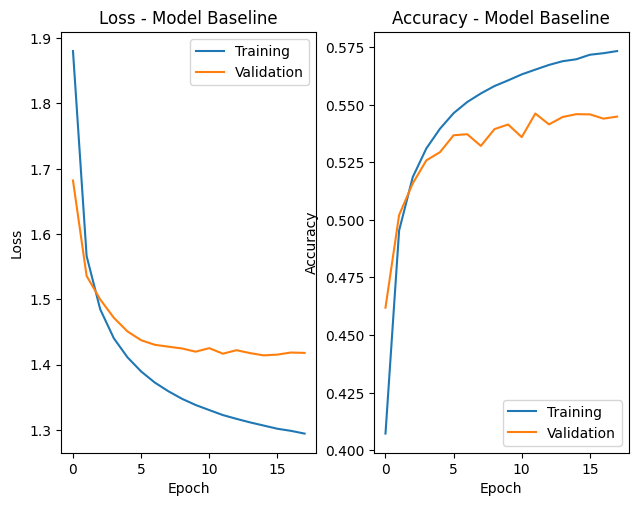

In [ ]:
# Plotting the history for performance
plot_performance(history_base, "Model Baseline")

The plots show that there is visible overfitting as the training accuracy (and loss, just lower) is much higher than the validation loss, where we have about 58% accuracy in train versus 54% in validation. This means that the model will be probably bad at adapting to new data, performing much worse than with train data. The default learning rate seems to be a good choice as it converges very fast, so for now it will be kept and not lowered.

#### **Building the Models: Model Baseline - Simple Evaluation**

Let's now evaluate the model using the test set obtained from the splitting. As seen in the previous section, we expect lower performance as there is some overfitting.


In [ ]:
# Evaluate on test set
test_loss_base, test_accuracy_base = model_base.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Baseline *****")
print(f"Test Loss: {test_loss_base:.4f}, Test Accuracy: {test_accuracy_base:.4f}")

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5356 - loss: 1.4364
***** Evaluation Results - Model Baseline *****
Test Loss: 1.4308, Test Accuracy: 0.5380


Indeed the model performes worse on test data, reaching about 54%, similar to the validation data. This suggests that we may need some regularization to help and mitigate the overfitting.

In [ ]:
# Testing using the seed_text
seed_text = "nel mezzo del cammin di nostra vita"

# Generating the text using the model
generated_text_base = generate_text(seed_text, model_base, length=400)
print("***** Model Baseline - Generated Text from: {} ***** \n{}".format(seed_text, generated_text_base))

***** Model Baseline - Generated Text from: nel mezzo del cammin di nostra vita ***** 
nel mezzo del cammin di nostra vita solla';
  e quindi la scalda sterpena e`, non s'adlorra,
  disselli i mentesmi la fama disteso,
  come tempi il fece che vivesta,
  se figlio scrisse? <<ancor faci;
  si` che 'l mondo spirto in cantando
  de' sangisi ove cenno consonaro.

quasi de' mederai avvertati soli?.

la` ma siete tempo avea la basca
  ed era penele innocen tanto, ch'eravami
  com'hi mosse, antella, se' stesso
  che dolente


The text generated obviously doesn't make sense, with some words being completely wrong, or << not being closed by >>, but it is able to generate some sentences.

### **Building the Models: Model Regularized - Using Dropout Layers**

This model focus is to reduce the overfitting found in the baseline model by adding a layer of Dropout. The value as been chosen to be 0.3 as a starting point.

#### **Building the Models: Model Regularized - Training**


In [ ]:
# LSTM Layer and a Dropout Layer for reducing overfitting
model_reg = Sequential()
model_reg.add(LSTM(128, input_shape=(maxlen, num_chars)))
model_reg.add(Dropout(0.3)) # 0.3 as starting point
model_reg.add(Dense(num_chars, activation='softmax'))  # Output Layer for each char

# Default Learning rate
optimizer_reg = RMSprop(learning_rate=0.01)

# Categorical_crossentropy as we are using onehot encoding
model_reg.compile(loss='categorical_crossentropy', optimizer=optimizer_reg, metrics=['accuracy'])

# Printing the model regularized summary
model_reg.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Using early stopping in case the model performance worsen earlier
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model regularized
history_reg = model_reg.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3197 - loss: 2.2632 - val_accuracy: 0.4515 - val_loss: 1.7121
Epoch 2/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4524 - loss: 1.7140 - val_accuracy: 0.4911 - val_loss: 1.5832
Epoch 3/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4794 - loss: 1.6269 - val_accuracy: 0.5051 - val_loss: 1.5356
Epoch 4/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4943 - loss: 1.5742 - val_accuracy: 0.5129 - val_loss: 1.5114
Epoch 5/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5034 - loss: 1.5432 - val_accuracy: 0.5235 - val_loss: 1.4846
Epoch 6/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5090 - loss: 1.5252 - val_accuracy: 0.5254 - val_loss: 1.4680
Epoch 7/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5131 - loss: 1.5099 - val_accuracy: 0.5280 - val_loss: 1.4602
Epoch 8/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5167 - loss: 1.4966 - val_accuracy

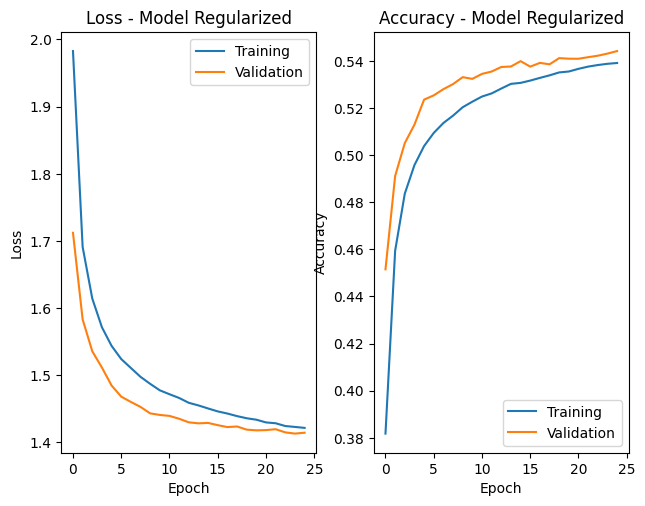

In [ ]:
# Plotting the history for performance
plot_performance(history_reg, "Model Regularized")

Introducing Dropout does affect the model quite a bit, as the performances in both training and validation are very similar, at around 54%, so like the baseline model but without overfitting whatsoever. It seems that are is instead a bit of underfitting, with the accuracy and loss still increasing and decreasing at the last epoch.

#### **Building the Models: Model Regularized - Simple Evaluation**


In [ ]:
# Evaluate on test set
test_loss_reg, test_accuracy_reg = model_reg.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Regularized *****")
print(f"Test Loss: {test_loss_reg:.4f}, Test Accuracy: {test_accuracy_reg:.4f}")

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5361 - loss: 1.4260
***** Evaluation Results - Model Regularized *****
Test Loss: 1.4237, Test Accuracy: 0.5374


The regularized model has basically the same performance as the baseline model on the test data, at 54%. The next step to maybe decrease the underfitting could be to increase the units and overall complexity of the network, being careful about overfitting.

In [ ]:
# Testing using the seed_text
seed_text = "nel mezzo del cammin di nostra vita"

# Generating the text using the model
generated_text_reg = generate_text(seed_text, model_reg, length=400)
print("***** Model Regularized - Generated Text from: {} ***** \n{}".format(seed_text, generated_text_reg))

***** Model Regularized - Generated Text from: nel mezzo del cammin di nostra vita ***** 
nel mezzo del cammin di nostra vita
  di mi latgura del cimol di tene,
  di si` che la` bai sapro suo mio a romando,

frenimando in noi perdenion non passa,
  poi ch'i' pero oavi fu' io mia,
  levando vesta lunguna musta vaporo,
  quel cerchio, quant'i' nu' nascoreglia
  di dio nobile che parlezzasi appeggia
  e disse lui, e con quanto era duba
  non ha e, malando divolde ambaschie
  de la luci
  che fa soveranza, une verso l'altan


The text generated is similar to what we have seen with the baseline model, but with better punctuation overall but still invented words and incoherent texts.

### **Building the Models: Model Units - Using 256 Units and One Layer**

This model focus is to improve the performance by increasing the amount to units. This will increase the complexity of the network so the Dropout value has been incresed to 0.4, trying to balance the added complexity.

#### **Building the Models: Model Units - Training**


In [ ]:
# LSTM Layer with 256 units and dropout layer
model_uni = Sequential()
model_uni.add(LSTM(256, input_shape=(maxlen, num_chars)))
model_uni.add(Dropout(0.4)) # Increased from 0.3 to 0.4
model_uni.add(Dense(num_chars, activation='softmax'))  # Output Layer for each char

# Default Learning rate
optimizer_uni = RMSprop(learning_rate=0.01)

# Categorical_crossentropy as we are using onehot encoding
model_uni.compile(loss='categorical_crossentropy', optimizer=optimizer_uni, metrics=['accuracy'])

# Printing the model optimal summary
model_uni.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 256)                 │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,408 (1.20 MB)

 Trainable params: 314,408 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Using early stopping in case the model performance worsen earlier
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model using also the validation data
history_uni = model_uni.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.2987 - loss: 2.4096 - val_accuracy: 0.4429 - val_loss: 1.7323
Epoch 2/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4524 - loss: 1.7133 - val_accuracy: 0.4944 - val_loss: 1.5687
Epoch 3/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.4881 - loss: 1.5927 - val_accuracy: 0.5155 - val_loss: 1.4919
Epoch 4/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5075 - loss: 1.5286 - val_accuracy: 0.5228 - val_loss: 1.4618
Epoch 5/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5194 - loss: 1.4890 - val_accuracy: 0.5324 - val_loss: 1.4374
Epoch 6/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5283 - loss: 1.4555 - val_accuracy: 0.5409 - val_loss: 1.4188
Epoch 7/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5373 - loss: 1.4309 - val_accuracy: 0.5443 - val_loss: 1.4018
Epoch 8/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5414 - loss: 1.4158 - 

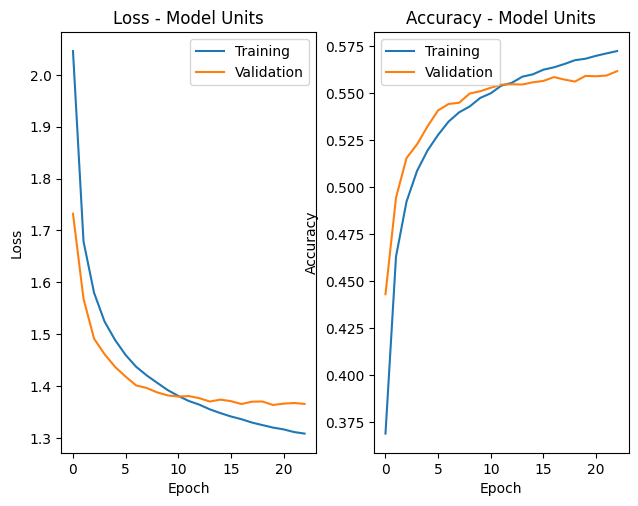

In [ ]:
# Plotting the history for performance
plot_performance(history_uni, "Model Units")

Increasing the units to 256 has indeed slightly improved the overall performance, as we have 57% in train versus 56% in validation. There is some very minor overfitting, even if the dropout value has been increased, but overall an improvement compared to the past two models.

#### **Building the Models: Model Units - Simple Evaluation**


In [ ]:
# Evaluate on test set
test_loss_uni, test_accuracy_uni = model_uni.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Units *****")
print(f"Test Loss: {test_loss_uni:.4f}, Test Accuracy: {test_accuracy_uni:.4f}")

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5507 - loss: 1.3812
***** Evaluation Results - Model Units *****
Test Loss: 1.3768, Test Accuracy: 0.5532


Increasing the units has indeed resulted in an increase of about 1% of accuracy, which is still a good improvement while also not being too far from the 57% accuracy performance seen in training. The next model will try to introduce another layer of LSTM and Dropout to increase the performance a little more.

In [ ]:
# Testing using the seed_text
seed_text = "nel mezzo del cammin di nostra vita"

# Generating the text using the model
generated_text_uni = generate_text(seed_text, model_uni, length=400)
print("***** Model Units - Generated Text from: {} ***** \n{}".format(seed_text, generated_text_uni))

***** Model Units - Generated Text from: nel mezzo del cammin di nostra vita ***** 
nel mezzo del cammin di nostra vita;
  e poi che conforta sotto devogia
  la teste centa, ma de l'alto nristrare.

ben l'un <<persono di bel suvi:
  mentr'io mi ligrise, quando non iginse,

malva di tu tratiti benettraffoci
  e io riperfetto ti porti e cacciata
  n'ha gente lezato de l'alto nargo;

ed e` questa galace mivoro m'epi,
  l'ali, una chiaccena per alva.

convien ch'e` miliaro, che menami:
  che fesse come averebbe assemm


The main difference in the text generation is the introdution of new characters like the ":" and a better structuring of the sentences.

### **Building the Models: Model Complex - 2 Layers LSTM and 2 Dropout Layers**

This model focus is to introduce two other layers: a LSTM (256 to 128) layer and a layer of dropout, to the "Model Units". This will hopefully help to both reduce the minor overfitting and increase the performance.

The first dropout layer, since it is closer to the input, uses a lower value of 0.3 while the second one is increased to 0.4.

#### **Building the Models: Model Complex - Training**


In [ ]:
# Two LSTM Layers and Two Dropout Layers for reducing overfitting
model_com = Sequential()
model_com.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_chars)))  # Uses onehot sequences
model_com.add(Dropout(0.3))
model_com.add(LSTM(128))
model_com.add(Dropout(0.4))
model_com.add(Dense(num_chars, activation='softmax'))  # Output Layer for each char

# Default Learning rate
optimizer_com = RMSprop(learning_rate=0.01)

# Categorical_crossentropy as we are using onehot encoding
model_com.compile(loss='categorical_crossentropy', optimizer=optimizer_com, metrics=['accuracy'])

# Printing the model complex summary
model_com.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 30, 256)             │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,408 (1.93 MB)

 Trainable params: 506,408 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Using early stopping in case the model performance worsen earlier
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model using also the validation data
history_com = model_com.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.2627 - loss: 2.5356 - val_accuracy: 0.4331 - val_loss: 1.7598
Epoch 2/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.4293 - loss: 1.7841 - val_accuracy: 0.4815 - val_loss: 1.6080
Epoch 3/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.4684 - loss: 1.6579 - val_accuracy: 0.5104 - val_loss: 1.5164
Epoch 4/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.4887 - loss: 1.5890 - val_accuracy: 0.5213 - val_loss: 1.4752
Epoch 5/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5034 - loss: 1.5389 - val_accuracy: 0.5295 - val_loss: 1.4390
Epoch 6/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.5130 - loss: 1.5078 - val_accuracy: 0.5378 - val_loss: 1.4197
Epoch 7/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5201 - loss: 1.4815 - val_accuracy: 0.5415 - val_loss: 1.4086
Epoch 8/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.5266 - loss: 1.4609 - 

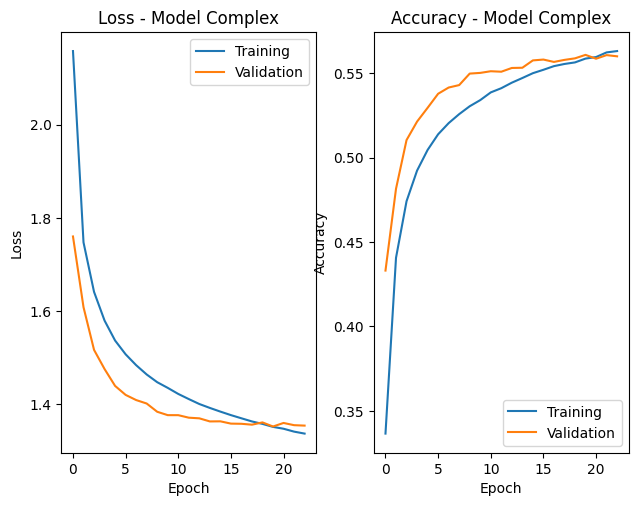

In [ ]:
# Plotting the history for performance
plot_performance(history_com, "Model Complex")

The performance plots show a slight improvement with the increased 'Model Units', without any signs of overfitting. This suggests that the model is likely to generalize better. The training and validation accuracy values are both around 56%. It is also important to say that during test trainings (not shown in this final report) this particular network did meet the Exploding Gradient problem (once), where the performance started to drastically lower after 15 or so epochs. This is probably due to an increased amount of layers.

#### **Building the Models: Model Complex - Simple Evaluation**


In [ ]:
# Evaluate on test set
test_loss_com, test_accuracy_com = model_com.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Complex *****")
print(f"Test Loss: {test_loss_com:.4f}, Test Accuracy: {test_accuracy_com:.4f}")

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5520 - loss: 1.3596
***** Evaluation Results - Model Complex *****
Test Loss: 1.3557, Test Accuracy: 0.5545


The test evaluation shows the best accuracy and especially loss values of the four models. Introducing some complexity seems to have helped the model, even if the general performance difference between the four models is not very significant.

In [ ]:
# Testing using the seed_text
seed_text = "nel mezzo del cammin di nostra vita"

# Generating the text using the model
generated_text_com = generate_text(seed_text, model_com, length=400)
print("***** Model Complex - Generated Text from: {} ***** \n{}".format(seed_text, generated_text_com))

***** Model Complex - Generated Text from: nel mezzo del cammin di nostra vita ***** 
nel mezzo del cammin di nostra vita,
  con le procedession verperice.

ove si movea terra mi vide omarin,

dinanzi innanzi a quel ch'e' possonti,
  or da sotto s'altra quivi era frange,
  ch'io con dolce dal nel foco del vero e` del diere invimo.

<<o molte confude dallata ebberte
  del sio suso ad un confinio e aloci lordarsi,
  verna ch'utor lo gran pianti fallati
  giusso la verssia lor fermin s'agnima>>.

io non coler che qui q


The text generation shows slightly longer sentences and also a correct usage of << and >>, but no major changes compared to the "Model Units".

## **Building the Models: Chunk Length Tuning**

This section focuses on finding a good chunk length, increasing the value from the baseline 30. Increasing the chunk length allows the model to process longer sequences of text at once. This means the model has a bigger context to learn from, capturing more dependencies between words or characters that are farther apart. This will also increase the training times, so the increase will not be extremely high.

There are two different models implemented, starting from the best one found in the structure tuning:

- **Model Optimal - 60 Chunk Length**: it uses the "Model Complex" with a doubled chunk length.
- **Model Optimal - 70 Chunk Length**: it uses the "Model Complex" with a slightly higher value than 60, to both increase the length but also contain the training times.

The only main difference from the "Model Complex" is the change from 0.4 to 0.3 for the second dropout layer, as with bigger chunk length, the overfitting should also be generally lower as it should help the model generalize better. In case the overfitting is still highly present, it will be increased back to 0.4.

### **Building the Models: Model Optimal - Chunk Length = 60**

This model focus is to use and increase the chunk length "maxlen" to 60, trying to improve the performance.

In [ ]:
# Main parameters to tune
maxlen = 60  # Chunk length increased to improve performance
step = 1     # Step = 1 to increase the size of sequences

# We will always use 0.1 for both val and test, as we splitted 80%, 10%, 10%
val_split = 0.1
test_split = 0.1

# Using the "prepare_text_data" function
X_train, X_val, X_test, y_train, y_val, y_test = prepare_text_data(
    text=text,
    chars=chars,
    maxlen=maxlen,
    step=step,
    val_split=val_split,
    test_split=test_split
)


Number of sequences: 558180

***** Text Splitting Results *****
X_train shape: (446544, 60, 40), y_train shape: (446544, 40)
X_val shape: (55818, 60, 40), y_val shape: (55818, 40)
X_test shape: (55818, 60, 40), y_test shape: (55818, 40)


#### **Building the Models: Model Optimal - Chunk Length = 60 - Training**


In [ ]:
# Two LSTM Layers and Two Dropout Layers for reducing overfitting
model_opt_60 = Sequential()
model_opt_60.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_chars)))  # Uses onehot sequences
model_opt_60.add(Dropout(0.3))
model_opt_60.add(LSTM(128))
model_opt_60.add(Dropout(0.3))
model_opt_60.add(Dense(num_chars, activation='softmax'))  # Output Layer for each char

# Default Learning rate
optimizer_opt_60 = RMSprop(learning_rate=0.01)

# Categorical_crossentropy as we are using onehot encoding
model_opt_60.compile(loss='categorical_crossentropy', optimizer=optimizer_opt_60, metrics=['accuracy'])

# Printing the model optimal summary
model_opt_60.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 256)             │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,408 (1.93 MB)

 Trainable params: 506,408 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Using early stopping in case the model performance worsen earlier
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model using also the validation data
history_opt_60 = model_opt_60.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.2653 - loss: 2.5293 - val_accuracy: 0.4386 - val_loss: 1.7505
Epoch 2/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.4459 - loss: 1.7262 - val_accuracy: 0.4880 - val_loss: 1.5831
Epoch 3/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4880 - loss: 1.5920 - val_accuracy: 0.5155 - val_loss: 1.4897
Epoch 4/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.5050 - loss: 1.5332 - val_accuracy: 0.5301 - val_loss: 1.4377
Epoch 5/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5188 - loss: 1.4851 - val_accuracy: 0.5321 - val_loss: 1.4375
Epoch 6/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5276 - loss: 1.4536 - val_accuracy: 0.5425 - val_loss: 1.3915
Epoch 7/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5354 - loss: 1.4277 - val_accuracy: 0.5462 - val_loss: 1.3828
Epoch 8/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5396 - loss: 1.4089 - 

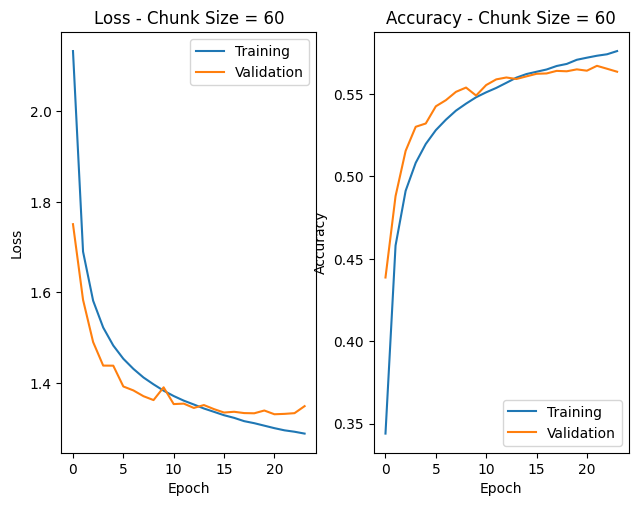

In [ ]:
# Plotting the history for performance
plot_performance(history_opt_60, "Chunk Size = 60")

For a simple comparation, let's print the Model Complex with 30 c.length performances:

- accuracy: 0.5660 - loss: 1.3271 - val_accuracy: 0.5600 - val_loss: 1.3538

While with 60 c.length:

- accuracy: 0.5783 - loss: 1.2792 - val_accuracy: 0.5635 - val_loss: 1.3480

We can see some minor overfitting being back but the general performances are a little better, especially looking at the loss.

#### **Building the Models: Model Optimal - Chunk Length = 60 - Simple Evaluation**


In [ ]:
# Evaluate on test set
test_loss_opt_60, test_accuracy_opt_60 = model_opt_60.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Optimal - Chunk Size = 60 *****")
print(f"Test Loss: {test_loss_opt_60:.4f}, Test Accuracy: {test_accuracy_opt_60:.4f}")

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5650 - loss: 1.3288
***** Evaluation Results - Model Optimal - Chunk Size = 60 *****
Test Loss: 1.3354, Test Accuracy: 0.5632


The "Model Complex" performances in test were:

- test Loss: 1.3557 - test Accuracy: 0.5545

So, again we see a very little increase in performance, which suggests that increasing the chunk length did help a little bit the model.

In [ ]:
# Testing using the seed_text
seed_text = "nel mezzo del cammin di nostra vita"

# Generating the text using the model
generated_text_opt_60 = generate_text(seed_text, model_opt_60, length=400)
print("***** Model Optimal - Chunk Size = 60 - Generated Text from: {} ***** \n{}".format(seed_text, generated_text_opt_60))

***** Model Optimal - Chunk Size = 60 - Generated Text from: nel mezzo del cammin di nostra vita ***** 
nel mezzo del cammin di nostra vita,
decgepivvdie iiitvaii e qui sole.

se piu` apparretti pria con qual sente.

<<o regno di crescer li meve giuro>>.

qual e` preso gentiro e i pie` sen terne,
  ucci quando soggionio vi travita,
  per centa del suo fattor la speranza,
  che tu mi segui vien val giu` son su` ch'istretti,
  ch'avaritare intelletto e la` suole>>.



paradiso: canto ii


e l'altro stato a man s'avellisco,
  cola` dove


The text generation seems much smoother and fluent, similar to the "divina commedia" compared to the previous models. There are still invented words and some noise especially in the beginning.

### **Building the Models: Model Optimal - Chunk Length = 70**

This model focus is to use and increase the chunk length "maxlen" to 70, trying to improve the performance from the previous section.





In [ ]:
# Main parameters to tune
maxlen = 70  # Chunk length increased to improve performance
step = 1     # Step = 1 to increase the size of sequences

# We will always use 0.1 for both val and test, as we splitted 80%, 10%, 10%
val_split = 0.1
test_split = 0.1

# Using the "prepare_text_data" function
X_train, X_val, X_test, y_train, y_val, y_test = prepare_text_data(
    text=text,
    chars=chars,
    maxlen=maxlen,
    step=step,
    val_split=val_split,
    test_split=test_split
)

Number of sequences: 558170

***** Text Splitting Results *****
X_train shape: (446536, 70, 40), y_train shape: (446536, 40)
X_val shape: (55817, 70, 40), y_val shape: (55817, 40)
X_test shape: (55817, 70, 40), y_test shape: (55817, 40)


#### **Building the Models: Model Optimal - Chunk Length = 70 - Training**


In [ ]:
# Two LSTM Layers and Two Dropout Layers for reducing overfitting
model_opt_70 = Sequential()
model_opt_70.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_chars)))  # Uses onehot sequences
model_opt_70.add(Dropout(0.3))
model_opt_70.add(LSTM(128))
model_opt_70.add(Dropout(0.3))
model_opt_70.add(Dense(num_chars, activation='softmax'))  # Output Layer for each char

# Default Learning rate
optimizer_opt_70 = RMSprop(learning_rate=0.01)

# Categorical_crossentropy as we are using onehot encoding
model_opt_70.compile(loss='categorical_crossentropy', optimizer=optimizer_opt_70, metrics=['accuracy'])

# Printing the model optimal summary
model_opt_70.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 70, 256)             │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 70, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,408 (1.93 MB)

 Trainable params: 506,408 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Using early stopping in case the model performance worsen earlier
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model using also the validation data
history_opt_70 = model_opt_70.fit(X_train, y_train, batch_size=512, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.2024 - loss: 2.8723 - val_accuracy: 0.3916 - val_loss: 1.9052
Epoch 2/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.4122 - loss: 1.8462 - val_accuracy: 0.4722 - val_loss: 1.6337
Epoch 3/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.4624 - loss: 1.6772 - val_accuracy: 0.4979 - val_loss: 1.5465
Epoch 4/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.4870 - loss: 1.5928 - val_accuracy: 0.5165 - val_loss: 1.4795
Epoch 5/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 44s 50ms/step - accuracy: 0.5024 - loss: 1.5422 - val_accuracy: 0.5270 - val_loss: 1.4501
Epoch 6/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.5129 - loss: 1.5031 - val_accuracy: 0.5372 - val_loss: 1.4191
Epoch 7/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.5228 - loss: 1.4731 - val_accuracy: 0.5414 - val_loss: 1.4085
Epoch 8/25
873/873 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.5281 - loss: 1.4544 - 

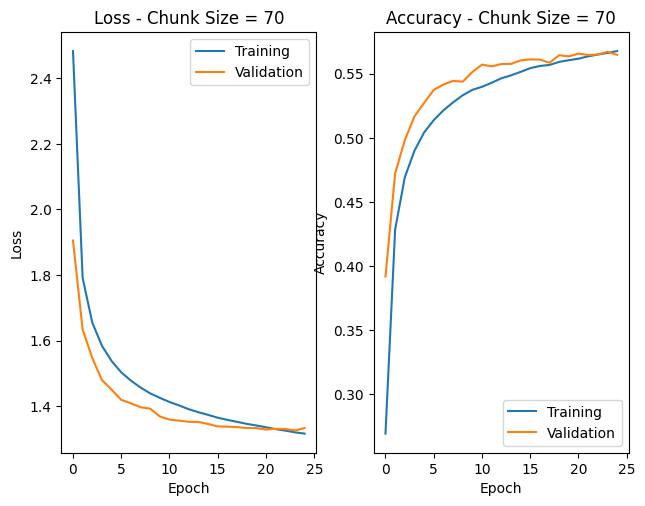

In [ ]:
# Plotting the history for performance
plot_performance(history_opt_70, "Chunk Size = 70")

Let's print the Model Complex with 60 c.length performances:

- accuracy: 0.5783 - loss: 1.2792 - val_accuracy: 0.5635 - val_loss: 1.3480

While with 70 c.length:

- accuracy: 0.5685 - loss: 1.3092 - val_accuracy: 0.5645 - val_loss: 1.3330


With the Chunk Length increased to 70 the overfitting is back to being irrelevant, while also having better performances in validation.

#### **Building the Models: Model Optimal - Chunk Length = 70 - Simple Evaluation**


In [ ]:
# Evaluate on test set
test_loss_opt_70, test_accuracy_opt_70 = model_opt_70.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Optimal - Chunk Size = 70 *****")
print(f"Test Loss: {test_loss_opt_70:.4f}, Test Accuracy: {test_accuracy_opt_70:.4f}")

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5712 - loss: 1.3190
***** Evaluation Results - Model Optimal - Chunk Size = 70 *****
Test Loss: 1.3235, Test Accuracy: 0.5685


The "Model Optimal - 60 Chunk Length" performances in test were:

- test Loss: 1.3354, test Accuracy: 0.5632

So, finally we see again better performances in test too, with also a model that has not real overfitting.

In [ ]:
# Testing using the seed_text
seed_text = "nel mezzo del cammin di nostra vita"

# Generating the text using the model
generated_text_opt_70 = generate_text(seed_text, model_opt_70, length=400)
print("***** Model Optimal - Chunk Size = 70 - Generated Text from: {} ***** \n{}".format(seed_text, generated_text_opt_70))

***** Model Optimal - Chunk Size = 70 - Generated Text from: nel mezzo del cammin di nostra vita ***** 
nel mezzo del cammin di nostra vitanmiiaairlhecielnvt dq  an; er
aoblimo la donna,
  se tu sia che venne oravar tutte
  probestinomente ne le braccia
  del cangiato verto a la spuola zamo,
  con l'ha si dichina cerchia duole
  corla da la veduta e cosa non pare
  a lei a contrario nottar de la testa
  le membra vince l'un centro demona,

e l'erizinte destra, e m'appeteta,
  ov'ella fu pur in alto paio
  ruma ch'ella, che per meco d


With an altered chunk length than the default 30 it seems that both the models (with 60 and 70 c. length) struggle with generating the first words after the given seed, but then adapt well and generate better and coherent text shortly afterwards. It seems like in this case the punctuation is very well used, but with more noise at the beginning.

# **Final Considerations and Comments**

This section summarises what has been found in the previous sections, while giving some final considerations.

## **Summary Table - Performance**

| Model                | Chunk Length | Train Acc. | Train Loss   | Val Acc. | Val Loss | Test Acc. | Test Loss |
|----------------------|--------------|----------|--------|--------------|----------|---------------|-----------|
| Baseline             | 30           | 0.5770   | 1.2827 | 0.5448       | 1.4179   | 0.5380        | 1.4308    |
| Regularized          | 30           | 0.5414   | 1.4133 | 0.5442       | 1.4144   | 0.5374        | 1.4237    |
| Units                | 30           | 0.5752   | 1.2991 | 0.5618       | 1.3662   | 0.5532        | 1.3768    |
| Complex              | 30           | 0.5660   | 1.3271 | 0.5600       | 1.3538   | 0.5545        | 1.3557    |
| Optimal  | 60           | 0.5783   | 1.2792 | 0.5635       | 1.3480   | 0.5632        | 1.3354    |
| Optimal | 70           | 0.5685   | 1.3092 | 0.5645       | 1.3330   | 0.5685        | 1.3235    |

## **Summary Table - Text Quality**

| Model |            Text Generation          |
|-------|-------------------------------------|
| Baseline             | Generated incoherent texts with mostly invented or distorted words. |
| Regularized        | Generated incoherent texts with mostly invented or distorted words. |
| Units                |  Medium quality with improved fluency and structure, though still containing nonsensical words. |
| Complex              | Medium quality with improved fluency and structure, though still containing nonsensical words. |
| Optimal - 60 | Best overall quality. The text is fluent, coherent, and closely resembles the style of the original work. |
| Optimal - 70 | Good quality, but slightly worse than Chunk Length = 60, with more errors and distorted words. |


The tables reveal a general improvement in performance as we progress from the baseline architecture, studied in class, to the "Optimal Model." The baseline model exhibited overfitting, as evidenced by the large gap between training and validation accuracy. However, the introduction of Dropout layers effectively mitigated this issue by regularizing the network, improving its ability to generalize. Additionally, using a step size = 1 during data preprocessing increased the number of training sequences, providing the model with more data to learn from, but at the cost of longer training times.

Tuning the model's structure showed that a slightly more complex architecture can get marginally better performance when combined with regularization techniques. However, the performance improvements were not dramatic, with accuracy on the test set peaking around 56/57%. This accuracy also should be the expected performance of the model on unseen text data, due to the successful reduction of overfitting, but considering how unique the way the "divina commedia" is written, it could perform worse aswell (for example on a modern text file).

Adjusting the chunk length had minimal impact on the models' performance metrics but influenced the quality of text generation. While the generated text initially appears noisy (with some weird text generated), it gradually transitions to sequences resembling correct sentences. It’s possible that using larger chunk lengths could further help with the generation but it seems that 60 is a good value, with text generation better than with c. length = 70.

In conclusion, while the LSTM models struggled to achieve high accuracy on this particular text file, they demonstrated the ability to generate text resembling grammatically plausible sentences from a given seed. These results show the model's potential in text generation tasks, with room for improvement in terms of predictive accuracy.

# **Appendix - Seen in Class**

## **Evaluation with Step = 3**

This follows the approach seen in class, with step = 3. As we have an higher step value less sequences will be generated, so we expect slightly lower performances. We will test this only with the baseline model used in the skeleton code with the accuracy metric.

In [ ]:
maxlen = 30  # Chunk length
step = 3

# We will always use 0.1 for both val and test, as we splitted 80%, 10%, 10%
val_split = 0.1
test_split = 0.1

# Using the "prepare_text_data" function
X_train, X_val, X_test, y_train, y_val, y_test = prepare_text_data(
    text=text,
    chars=chars,
    maxlen=maxlen,
    step=step,
    val_split=val_split,
    test_split=test_split
)

Number of sequences: 186070

***** Text Splitting Results *****
X_train shape: (148856, 30, 40), y_train shape: (148856, 40)
X_val shape: (18607, 30, 40), y_val shape: (18607, 40)
X_test shape: (18607, 30, 40), y_test shape: (18607, 40)


In [ ]:
# Model Baseline seen in class
model_cls = Sequential()
model_cls.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_cls.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model_cls.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_cls.summary()

# mininum architecture

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import sys
import random # Import the random module

def testAfterEpoch(epoch, _):
  print()
  print()
  print("***** Epoch: %d ******" % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)


  generated = ""
  sentence = text[start_index : start_index + maxlen]
  generated = generated + sentence

  print("***** starting sentence *****")
  print(sentence)
  print("*************************")
  sys.stdout.write(generated)

  # 400 words
  for i in range(400):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t,char in enumerate(sentence):
      x_pred[0, t, char_indices[char]]=1
    preds = model_cls.predict(x_pred, verbose = 0)[0]
    next_index = np.argmax(preds)
    # reverse map used for the encoding step
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()

In [ ]:
print_callback = LambdaCallback(on_epoch_end =testAfterEpoch)

In [ ]:
history_cls = model_cls.fit(X_train,y_train, batch_size=2048, epochs = 20, validation_data=(X_val, y_val), callbacks = [print_callback])

Epoch 1/20
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1794 - loss: 2.9930

***** Epoch: 1 ******
***** starting sentence *****
i giove
  tra 'l padre e 'l fi
*************************
i giove
  tra 'l padre e 'l fia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia lia che sia li
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 377ms/step - accuracy: 0.1814 - loss: 2.9808 - val_accuracy: 0.2920 - val_loss: 2.3065
Epoch 2/20
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3242 - loss: 2.2071

***** Epoch: 2 ******
***** starting sentence *****
a e vole,

ancor diro`, perche
*************************
a e vole,

ancor diro`, perche l'alla mande la per di sua la 

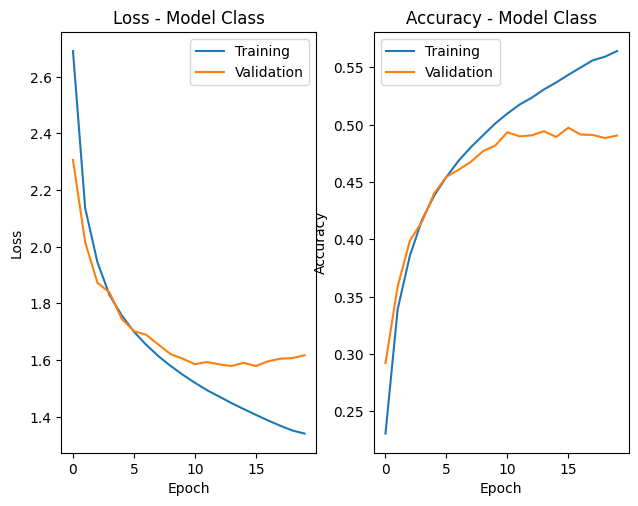

In [ ]:
# Plotting the history for performance
plot_performance(history_cls, "Model Class")

Like with step = 1 we can see that the model overfits similarly on the training data.


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model_cls.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"***** Evaluation Results - Model Class *****")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4856 - loss: 1.6694
***** Evaluation Results - Model Class *****
Test Loss: 1.6441, Test Accuracy: 0.4886


As expected it got worse performance that with step = 1 (with around 54% of accuracy in test). Decreasing the step to 1 impacts much more than the tuning process itself.